Clément Yvernes & Samuel Bounan

# Report: elaboration of an artificial Pickomino player

## Part I

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from game import *

### Part 1.1) Implementation

#### Part 1.1.1) Implementation of the one turn game

The full implementation is available in the Player class of players.py.

The "W" result of a dice have been represented by a 0.

An important precaution has been taken to speed up the calculations:

The previous choices have been implemented on a single bit. All operations are performed by very fast bitwise operations.

The function that calculates the strategy has been separated from the function that calculates the expected gain of a state. By memoizing these functions, the complete calculation of the strategy for a given reward vector takes less than two tenths of a second.



#### Part 1.1.2) Tests

We can test the strategy function by estimating the true expectancy of the strategy. To do so, the following code simulates a single round for N times and computes the estimated expectancy. The experiment have been run on 10 000 000 samples (~ 11 min), the estimated expectancy was 1.6447063. The player's expectancy method computes an expectancy of 1.6447296740400978.  The Central Limit Theorem tells us that we should get the correct value up to approximatively 3 digits.Therefore, it is very likely that the strategy method is correct.

In [13]:
player = Player()
print("player's expectancy:", player.expectancy(0, 8, 0))

player's expectancy: 1.6447296740400978


In [14]:
average_reward = 0
N = 100000
for idx in range(N):
    nb_available_dice = 8
    score = 0
    previous_choices = 0
    for i in range(8): # At each turn, the number of dice is decreased by at least one (or the round is stopped). Thus we do at most 8 turns.
        # Draw the dice
        dice_results = draw_dice(nb_available_dice)
        
        # Send the result to the play and let them chose what to do
        player_choice = player.play_dice(dice_results, previous_choices, nb_available_dice, score)

        if player_choice is None:# The Player can't choose, the round is failed
            average_reward += -player.C
            break
        else:
            score += (player_choice[0] if player_choice[0] else 5)*dice_results[player_choice[0]]
            previous_choices |= 1 << player_choice[0]
            if player_choice[1]:# Player decides to continue
                nb_available_dice -= dice_results[player_choice[0]]
                continue
            else:# player decides to stop
                average_reward += player.rewardfun(score, previous_choices) 
                break

         
average_score = average_reward / N
print("Estimated expectancy of reward:", average_score)

KeyboardInterrupt: 

### Part 1.2) Results

Illustration of our code with throw: (1, 3, 3, 3, 4, 4, 5, W ).

In [ ]:
player = Player()
initial_throw = dice2state((1, 3, 3, 3, 4, 4, 5, 0))
print(player.strategy(initial_throw, 0, 8, 0))


((4, 1), 1.384705294524559)


Thus the strategy chooses to take the two 4s, with an expected reward of ~1.3847 pickominos. If we change the `C` value, the same dice is chosen but the expected reward is now different.

In [ ]:
player.set_C(3)
initial_throw = dice2state((1, 3, 3, 3, 4, 4, 5, 0))
print(player.strategy(initial_throw, 0, 8, 0))

((4, 1), 0.6866167395787997)


One can also compute the maximal probability of obtaining a Pickomino with `i` or more pickominos: by putting the reward of obtaining a pickomino with `i` or more pickominos to 1 and the other to 0, the expected reward will directly be the probability we want.

In [ ]:
player = Player()
player.set_C(0)
basic_r = [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]

for i in range(1, 5):
    reward_vec = [r >= i for r in basic_r]
    player.set_r(reward_vec)
    print(f"Proba to have {i} or more pickominos: {player.expectancy(0,8,0):.3f}")

Proba to have 1 or more pickominos: 0.893
Proba to have 2 or more pickominos: 0.680
Proba to have 3 or more pickominos: 0.346
Proba to have 4 or more pickominos: 0.087


We can use the same idea of modifying the reward vector to compute the maximal probability of obtaining exactly Tile 24. However, we can't use PLayer class to do so. Indeed, a PLayer will take the best tile available under its score. To compute this quantity, we need a player that picks the tile corresponding to its score. This as been implemented by the Player_select_Tile_equal_score class.

In [ ]:
player_designed_for_this_question = Player_select_Tile_equal_score()
player_designed_for_this_question.set_r([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0])
print(player_designed_for_this_question.expectancy(0,8,0))

0.3750601883516782


We can compute the maximum probability of obtaining exactly each tile:

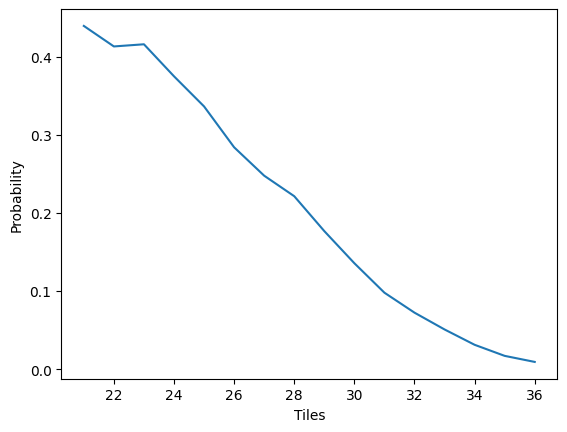

In [ ]:
player_designed_for_this_question = Player_select_Tile_equal_score()

basic_r = [0]*16
tiles = []
maximum_probability = []
for i in range(16):
    temp = basic_r.copy()
    temp[i] = 1
    player_designed_for_this_question.set_r(temp)
    tiles.append(21 + i)
    maximum_probability.append(player_designed_for_this_question.expectancy(0,8,0))
    
plt.plot(tiles, maximum_probability, label="Maximum probability to reach the desired tile")
plt.xlabel("Tiles")
plt.ylabel("Probability")
plt.show()

... or Tile 27 or higher

In [ ]:
player.set_r([0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1])
print(player.expectancy(0,8,0))

0.5247594468429357


We can compute this quantity for any score from 21 to 36

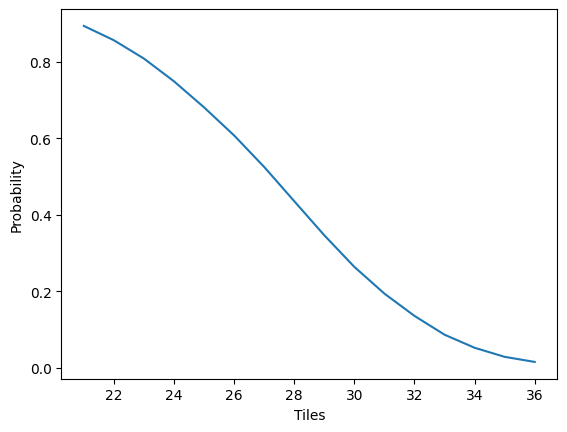

In [ ]:
temp = [1]*16
tiles = []
probability = []
for i in range(16):
    if i:
        temp[i-1] = 0
    player.set_r(temp)
    tiles.append(21 + i)
    probability.append(player.expectancy(0,8,0))
    
plt.plot(tiles, probability, label="Probability to reach the desired tile or higher")
plt.xlabel("Tiles")
plt.ylabel("Probability")
plt.show()

## Part II



## 2.1 Gradient Descent

We can compute the best parameters $\alpha$ and $\beta$ aggainst an adversary Alpha-Beta (1,1) through gradient descent. We have access (by simulation) of an approximation of the expected score obtained by a fixed player aggainst this adversary. It suffices to run an amount of game and to return the mean of the differences of scores between the two players. Noting $l = score(Adversary) - score(Player)$, the objective is to minimize the loss. The idea is then to compute directly the gradient, using:

$$ \nabla l = \frac{l(x+h)-l(x)}{h} $$

And then to update the parameters $ x = (\alpha, \beta) $ with this gradient:

$$ x = a \nabla l (x) $$

with $a$ the learning rate. We took it degressive in $\frac{1}{epoch}$

In [ ]:
gd = GD(n_epochs=50,n_batchs=10)
gd.gradient_descent()

KeyboardInterrupt: 

In [ ]:
epochs = range(3)
plt.plot(epochs, gd.alphas)
plt.plot(epochs, gd.betas)
plt.legend(["alphas", "betas"])

NameError: name 'plt' is not defined

### 2.2 Genetic Algorithm

One of the ideas we came up with to find the optimum $\alpha$ and $\beta$ was to use a genetic algorithm. We give ourselves a population of players with different $\alpha$ and $\beta$. We let these players play a large number of games against player 1,1 and measure the average score they obtain against it. The players whose scores compared with the score of player 1,1 are the highest are selected. These players can then reproduce to form the next generation of players. Mutations are added into the process to alllow the population to improve. The full implementation is available in the file genetique.py

It has been difficult to find the right learning parameters, as the scores are very noisy. Even with 1000 games per player, scores are still very noisy. Increasing the number of games per player is not really feasible if one wants a reasonable computation time. Nevertheless, a large number of $\alpha$ $\beta$ seem to beat player 1,1.  This seems to show that the 1.1 strategy is not very effective.

### 2.3 Q Learning

To answer the last question our initial idea was to use Q-learning. Indeed the game seems to have a finite set of actions and states, and we need a strategy that can adapt more than Alpha-Beta strategies. Theses strategies are limited because they have fixed paramaters controlling what dominos you prefer and the risk you take. In reality these parameters can change according to the state. For instance if you have a high second domino in your stack of dominos it will be better to play less risky do protect it, than if you have only the top stack domino. If Alpha-Beta will not differentiate theses two states (it does not consider the second domino), there is a little difference between them.

First issue with applying Q-learning is the dimension of the state space. If we encode the grill (16 bits), the stack of your dominos (16 potential dominos * 4 bits to encode the value), and your adversary stack, it counts a total of 2**144 states. A solution we explore is to encode Q function with a Neural Network approximating the value of the function.

Second issue was the dimension of the action space. As the reward vector used to choose dice influences the scores obtained at the end that are directly linked to the domino picked, and thus to the rewards and the new state obtained after, it has to be variable and modifiable via the actions. More than that, if the reward vector r is fixed and considered the real expected rewards, then the optimal strategy to choose dice is fixed too, and the domino choice also (take the domino that gives the best reward). Moreover, in the reward vector modified with  $\alpha$ and $\beta$ constants, two dominos have the same rewards iff the situation are equivalent in the real game situation. Finally $\alpha$ and $\beta$ seems necessary and sufficient to parametrize the possible dice strategies and domino strategies, and we chose to choose them as the possible actions.

Then, the set of actions becomes $\mathbb{R}^{+2}$. The problem is now to deal with continuous action space, as taking a max in the Bellman equation is not easily done. We finally chose, after reading on some basic explanation of what is done in approaches like Actor-Critic, to have a network that takes a state and that returns an action $(\alpha, \beta)$ and a value. What we can do with this network is an approximation of the TD error:

$$ R + \gamma max_a(Q(s_{t+1},a)) - Q(s_t, A) $$

$R$ can directly be derived from simulation of one step, and to compute the $max$ we can discretise the values of $\alpha$ and $\beta$, to simulate one step, reaching state $s_{t+2}$ and to return $max_a (s_{t+2})$. We finally approximate the TD error with:

$$ R + \gamma max_a(Q(s_{t+2})) - Q(s_t) $$

And this value can be used to compute the loss used for gradient descent in our network. We also added to the loss the mean square error of the best parameters $(\alpha, \beta)$ found with the dicretisation and the $(\alpha, \beta)$ obtained by the network.

In [ ]:
from agent import *

# Initialize the network and optimizer
net = Actor()
agent = Agent(net)
optimizer = optim.Adam(agent.net.parameters(), lr=LR)

In [ ]:
# Training loop

alphas = []
betas = []
losses = []

for epoch in range(5):
    
    agent.game.reinit()

    while not agent.game.over():

        # Use the model to return an action
        state = state2tensor(agent.game.grill, agent.me.dominos, agent.adv.dominos)
        alpha, beta, val = agent.net(state)
        agent.me.set_ab(alpha.item(), beta.item())
        alphas.append(alpha.item())
        betas.append(beta.item())

        reward = agent.game.play_turn(agent.me, agent.adv)
        if not agent.game.over():
            reward -= agent.game.play_turn(agent.adv, agent.me)
        print(f"step done {alpha.item():.2f} - {beta.item():.2f} : {val.item():.2f} with reward {reward}")

        # Simulate
        max_val = None
        best_alpha = None
        best_beta = None
        for a in np.logspace(-2, 1, 10):
            for b in np.logspace(-2, 1, 10):
                v = agent.simulator(a, b)
                if max_val == None or v > max_val:
                    max_val = v
                    best_alpha = a
                    best_beta = b
        print(f"simu done {best_alpha:.2f} - {best_beta:.2f} : {max_val:.2f}")

        # Loss
        optimizer.zero_grad()
        loss = (reward + GAMMA*max_val - val) + LOSS_AB*((best_alpha-alpha)**2 + (best_beta-beta)**2)
        loss.backward()
        optimizer.step()
        print(f"optimization done: loss = {loss.item()}")
        losses.append(loss.item())

    print(f"Epoch {epoch+1} done")

step done 0.56 - 0.84 : 0.40 with reward 2
simu done 0.01 - 1.00 : 3.22
optimization done: loss = 8.046875
step done 0.04 - 2.42 : 0.50 with reward 0
simu done 0.05 - 0.05 : 3.42
optimization done: loss = 59.05575180053711
step done 0.09 - 1.34 : 0.56 with reward 0
simu done 0.22 - 4.64 : 5.23
optimization done: loss = 114.06278991699219
step done 0.18 - 1.45 : 0.34 with reward 3
simu done 10.00 - 2.15 : 3.70
optimization done: loss = 976.3892822265625
step done 0.09 - 1.19 : 0.59 with reward -3
simu done 0.05 - 2.15 : 5.23
optimization done: loss = 10.9297513961792
step done 0.21 - 1.55 : 0.29 with reward 0
simu done 0.02 - 0.02 : 4.12
optimization done: loss = 27.50309181213379
step done 0.10 - 1.40 : 0.53 with reward -4
simu done 0.02 - 10.00 : 6.80
optimization done: loss = 741.3935546875
step done 0.24 - 1.83 : 0.40 with reward 5
simu done 0.01 - 10.00 : 3.56
optimization done: loss = 675.8690185546875
Epoch 1 done
step done 0.54 - 0.84 : 0.41 with reward 2
simu done 0.46 - 0.10 :

KeyboardInterrupt: 

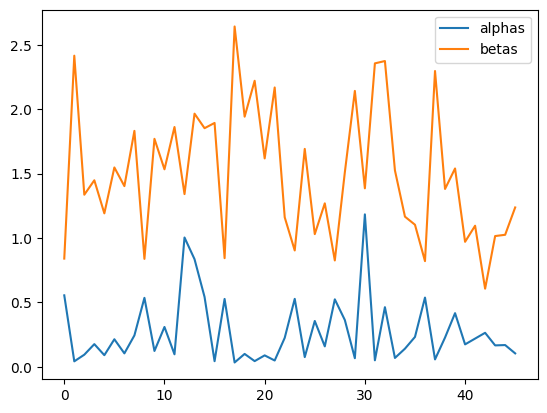

In [ ]:
steps = [k for k in range(len(alphas))]
plt.plot(steps, alphas)
plt.plot(steps, betas)
plt.legend(["alphas", "betas"])

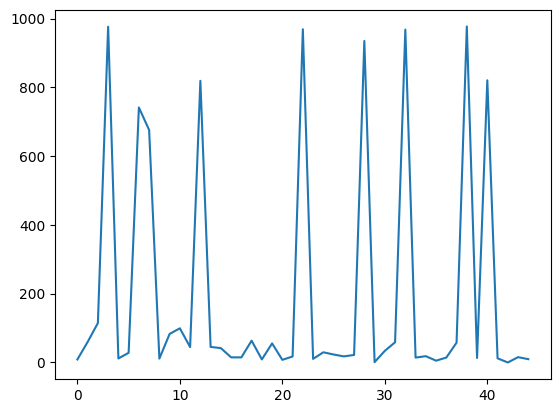

In [ ]:
steps_losses = [k for k in range(len(losses))]
plt.plot(steps_losses, losses)

As the parameters $\alpha$ and $\beta$ do not stabilise over time, we see that the method does not converge at all. One structural reason of this problem is that we use the return value of the network to compute the loss, and this makes the learning really unstable. A better approach could be to use a policy gradient algorithm, that does not need to assign values to states, and that only directly uses simulations of games to derive the rewards and compute the losses. However it still has to be adapted with continuous action space, and it makes the problem a bit more complex than the simple finite action space case. We didn't managed to find something satisfying in time.